# Library and Setting

In [1]:
import numpy as np
import pandas as pd
import re
import collections
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

In [2]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sb

In [3]:
pd.set_option('display.max_columns', 50)

# Data Inspection

In [4]:
aws_raw = pd.read_csv('../aws/aws.csv')
aws_raw.shape

(16824, 27)

In [5]:
# aws_raw.sample(5)

In [6]:
azure_raw = pd.read_csv('../azure/azure.csv')
azure_raw.shape

(4494, 11)

In [7]:
# azure_raw.sample(5)

# Data Cleaning

## <font color=blue> AWS </font>

### <font color=green> Discard unwanted columns and reorder columns </font>

In [8]:
# aws_raw.columns.tolist()

In [9]:
aws_dum = aws_raw[['title','id_icims','posted_date','city','state','country_code',\
                     'description','basic_qualifications','preferred_qualifications',\
                     'updated_time','location','normalized_location','company_name',\
                     'business_category','job_category','job_family','team',
                     'primary_search_label','optional_search_labels']]

In [10]:
# aws_dum.sample(5)

### <font color=green> Handle missing values </font>

In [11]:
# np.sum(aws_dum.isnull())

In [12]:
# fill with empty strings
aws_dum = aws_dum.fillna('')

### <font color=green> Edit text columns </font>

In [13]:
# all the text columns
aws_text_cols = ['title','description', 'basic_qualifications', 'preferred_qualifications',\
            'company_name','business_category', 'job_category', 'job_family', 'team',\
            'primary_search_label', 'optional_search_labels']

In [14]:
for col in aws_text_cols:
    aws_dum[col] = aws_dum[col].str.lower()
    # replace any non-alphanumeric characters to space
    # all foriegn letters will also be removed
    aws_dum[col] = aws_dum[col].apply(lambda x: re.sub('[^0-9a-z]+',' ',x))
    # replace multiple spaces with one space
    aws_dum[col] = aws_dum[col].apply(lambda x: re.sub(' +',' ',x))
    # strip leading and trailing spaces
    aws_dum[col] = aws_dum[col].str.strip()
    # replace 'amazon web services' with 'aws'
    aws_dum[col] = aws_dum[col].str.replace('amazon web services', 'aws')

### <font color=green> Get coutry name and continent </font>

In [15]:
countries = pd.read_csv('countries.csv',delimiter=';')
countries = countries[['Country','Country code','Continent']]
countries.columns = ['country','country_code','continent']

In [16]:
aws_dum['country_code'] = aws_dum['country_code'].str.replace('UK','GB')

In [17]:
aws_dum = pd.merge(aws_dum,countries,how='left',on='country_code')

### <font color=green> Change 'posted_date' and 'updated_time' to time series </font>

In [18]:
aws_dum['posted_date'] = pd.to_datetime(aws_dum['posted_date'])

In [19]:
def apply_offset(updated):
    """apply the offset in updated_time to convert it to a timestamp"""
    offset = re.search('\d+',updated).group()
    label = re.search('hour|day|month|year',updated).group()
    if offset and label:
        if label == 'year':
            updated = pd.Timestamp.today() + pd.DateOffset(years=-int(offset))
        elif label == 'month':
            updated = pd.Timestamp.today() + pd.DateOffset(months=-int(offset))
        elif label == 'day':
            updated = pd.Timestamp.today() + pd.DateOffset(days=-int(offset))
        elif label == 'hour':
            updated = pd.Timestamp.today() + pd.DateOffset(hours=-int(offset))
        else:
            print('No label found?', updated)
            updated = pd.Timestamp.today()
    else:
        print('No offset and label found?', updated)
        updated = pd.Timestamp.today()
        
    return(updated)

In [20]:
aws_dum['updated_time'] = aws_dum['updated_time'].map(apply_offset)

### <font color=green> Copy to aws_clean </font>

In [21]:
aws_clean = aws_dum
# aws_clean.sample(5)

## <font color=blue> Azure </font>

### <font color=green> Discard unwanted columns and reorder columns </font>

In [22]:
# azure_raw.columns.tolist()

In [23]:
azure_dum = azure_raw[['title','job_id','date','location','description','responsibilites',
                         'qualifications','profession']]

In [24]:
# azure_dum.sample(5)

### <font color=green> Handle missing values </font>

In [25]:
# np.sum(azure_dum.isnull())

In [26]:
# Drop rows with missing titles and descriptions
azure_dum = azure_dum.dropna(how='any')

### <font color=green> Edit text columns </font>

In [27]:
# all the text columns
azure_text_cols = ['title','description', 'responsibilites', 'qualifications', 'profession']

In [28]:
for col in azure_text_cols:
    azure_dum[col] = azure_dum[col].str.lower()
    # replace any non-alphanumeric characters to space
    # all foriegn letters will also be removed
    azure_dum[col] = azure_dum[col].apply(lambda x: re.sub('[^0-9a-z]+',' ',x))
    # replace multiple spaces with one space
    azure_dum[col] = azure_dum[col].apply(lambda x: re.sub(' +',' ',x))
    # strip leading and trailing spaces
    azure_dum[col] = azure_dum[col].str.strip()

### <font color=green> Split City/State/Country and get country code </font>

In [29]:
azure_dum['city'] = azure_dum['location'].apply(lambda x: x.split(',')[0].strip())
azure_dum['state'] = azure_dum['location'].apply(lambda x: x.split(',')[1].strip())
azure_dum['country'] = azure_dum['location'].apply(lambda x: x.split(',')[2].strip())

In [30]:
azure_dum['country'] = azure_dum['country'].str.replace('Hong Kong SAR','Hong Kong')
azure_dum['country'] = azure_dum['country'].str.replace('Korea','South Korea')
azure_dum['country'] = azure_dum['country'].str.replace('Côte d\'Ivoire','Ivory Coast')

In [31]:
azure_dum = pd.merge(azure_dum,countries,how='left',left_on='country',right_on='country')
# check if there are unmatched countries
# np.sum(azure_dum['country_code'].isnull())
# azure_dum.loc[azure_dum['country_code'].isnull(), 'country']

### <font color=green> Change 'date' to time series </font>

In [32]:
azure_dum['date'] = pd.to_datetime(azure_dum['date'])

### <font color=green> Copy to azure_clean </font>

In [33]:
azure_clean = azure_dum
# azure_clean.sample(5)

# Select Pure Sample

The search results from the career websites include every job position that mentions the key words at some point. Therefore some job positions are actually not relevant. We need to select a pure sample that only includes related positions.

## <font color=blue> AWS </font>

Explore to see what's the best way to select a pure sample.

In [34]:
test_cols = aws_clean[['title','description']]
test = test_cols.apply(lambda x: x.str.contains('aws')).any(axis=1)

In [35]:
test.value_counts()

True     14421
False     2403
dtype: int64

In [36]:
label_cols = aws_clean[['company_name','business_category','job_category','job_family',
                  'team','primary_search_label','optional_search_labels']]
pure = label_cols.apply(lambda x: x.str.contains('aws')).any(axis=1)

In [37]:
pure.value_counts()

True     13324
False     3500
dtype: int64

In [38]:
# aws_clean[np.logical_and(test == True, pure != True)].shape
# aws_clean[np.logical_and(test != True, pure == True)].shape
# aws_clean[np.logical_and(test == True, pure == True)].shape
# aws_clean[np.logical_and(test != True, pure != True)].shape

In [39]:
# take a look at the data
# aws_clean[np.logical_and(test != True, pure == True)]

Select jobs that have 'aws' in 'title' or 'description'.

In [40]:
mask = aws_clean[['title','description']].apply(lambda x: x.str.contains('aws')).any(axis=1)
aws_pure = aws_clean[mask]

In [41]:
aws_pure.shape[0]/aws_clean.shape[0]

0.8571683309557775

## <font color=blue> Azure </font>

Explore.

In [42]:
test_cols = azure_clean[['title','description','responsibilites']]
test = test_cols.apply(lambda x: x.str.contains('azure')).any(axis=1)

In [43]:
test.value_counts()

True     3723
False     714
dtype: int64

Select jobs that have 'azure' in 'title', 'description', or 'responsibilites'.

In [44]:
mask = azure_clean[['title','description','responsibilites']].apply(
                                               lambda x: x.str.contains('azure')).any(axis=1)
azure_pure = azure_clean[mask]

In [45]:
azure_pure.shape[0]/azure_clean.shape[0]

0.8390804597701149

# Data Analysis

In [46]:
aws = aws_pure
azure = azure_pure

## <font color=blue> Market share </font>

In [47]:
comp_ratio = pd.DataFrame([['# of Job Postings',aws.shape[0]/azure.shape[0],'AWS'],
                           ['# of Job Postings',1,'Azure'],
                           ['Market Share',47/22,'AWS'],
                           ['Market Share',1,'Azure']],
                           columns = ['','Ratio','Company'])

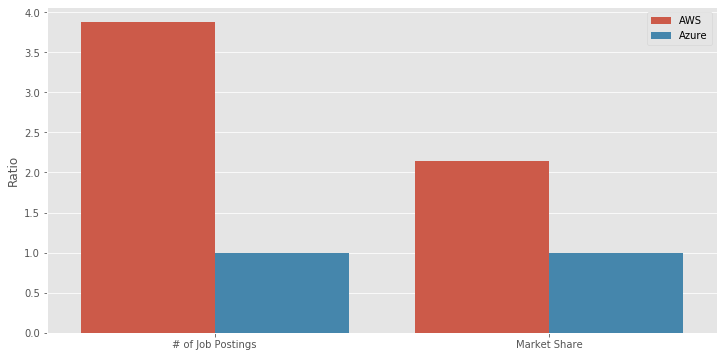

In [48]:
plt.figure(figsize=(12,6))
sb.barplot(comp_ratio[''], comp_ratio['Ratio'], 
                comp_ratio['Company'],hue_order=['AWS','Azure'])
plt.legend(loc='upper right')
plt.savefig('ratio_plot.png')

### <font color=green> Conclusion</font>

AWS' market shares doubles that of Azure. Its job postings are four times more than Azure.

## <font color=blue> Geographical characteristics </font>

In [49]:
aws_continent = aws.groupby('continent').size().sort_values(ascending=False)/aws.shape[0]*100
azure_continent = azure.groupby('continent').size().sort_values(ascending=False)/azure.shape[0]*100

In [50]:
aws_continent = pd.DataFrame(aws_continent).reset_index()
aws_continent['company'] = 'AWS'

In [51]:
azure_continent = pd.DataFrame(azure_continent).reset_index()
azure_continent['company'] = 'Azure'

In [52]:
comp_continent = pd.concat([aws_continent,azure_continent])
comp_continent.columns = ['Continent','Percentage','Company']

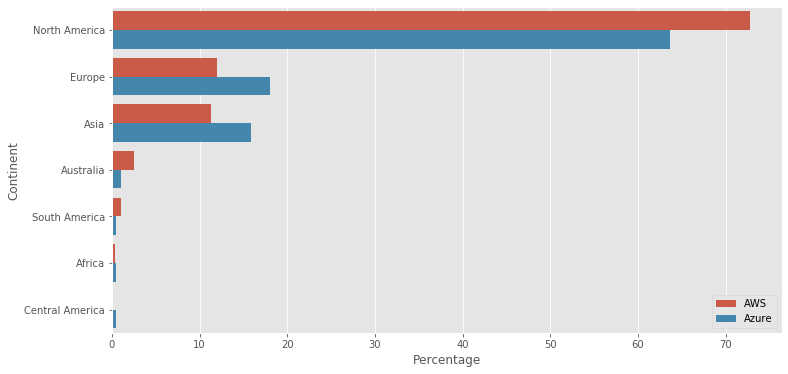

In [53]:
plt.figure(figsize=(12,6))
sb.barplot(comp_continent['Percentage'], comp_continent['Continent'], 
                comp_continent['Company'],hue_order=['AWS','Azure'])
plt.legend(loc='lower right')
plt.savefig('continent_plot.png')

In [54]:
comp_market = pd.DataFrame([
    ['Domestic',np.sum(aws['country_code'] == 'US')/aws.shape[0]*100, 'AWS'],
    ['International',np.sum(aws['country_code'] != 'US')/aws.shape[0]*100, 'AWS'],
    ['Domestic',np.sum(azure['country_code'] == 'US')/azure.shape[0]*100, 'Azure'],
    ['International',np.sum(azure['country_code'] != 'US')/azure.shape[0]*100, 'Azure']],
      columns = ['Area','Percentage','Company'])

In [55]:
comp_market

,Area,Percentage,Company
0,Domestic,67.477983,AWS
1,International,32.522017,AWS
2,Domestic,62.181037,Azure
3,International,37.818963,Azure


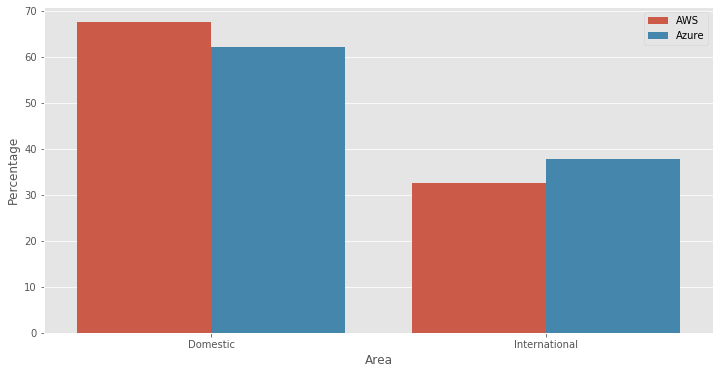

In [56]:
plt.figure(figsize=(12,6))
sb.barplot(comp_market['Area'], comp_market['Percentage'], 
                comp_market['Company'],hue_order=['AWS','Azure'])
plt.legend(loc='upper right')
plt.savefig('market_plot.png')

### <font color=green> Conclusion</font>

For the ratio of domestic vs international market, AWS is higher than Azure.

## <font color=blue> Time series </font>

In [57]:
aws_date = 'updated_time' # posted_date,updated_time
aws.loc[:,'year_month'] = aws.loc[:,aws_date].dt.to_period('M')
azure.loc[:,'year_month'] = azure.loc[:,'date'].dt.to_period('M')

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [58]:
aws_time = aws.groupby('year_month').size()/aws.shape[0]*100
azure_time = azure.groupby('year_month').size()/azure.shape[0]*100

In [59]:
aws_time = pd.DataFrame(aws_time).reset_index()
aws_time = aws_time[aws_time['year_month'] > pd.Timestamp('2019-08')]
aws_time['company'] = 'AWS'

In [60]:
azure_time = pd.DataFrame(azure_time).reset_index()
azure_time = azure_time[azure_time['year_month'] > pd.Timestamp('2019-08')]
azure_time['company'] = 'Azure'

In [61]:
comp_time = pd.concat([aws_time,azure_time])
comp_time.columns = ['Time','Percentage','Company']

In [62]:
comp_time.dtypes

Time          period[M]
Percentage      float64
Company          object
dtype: object

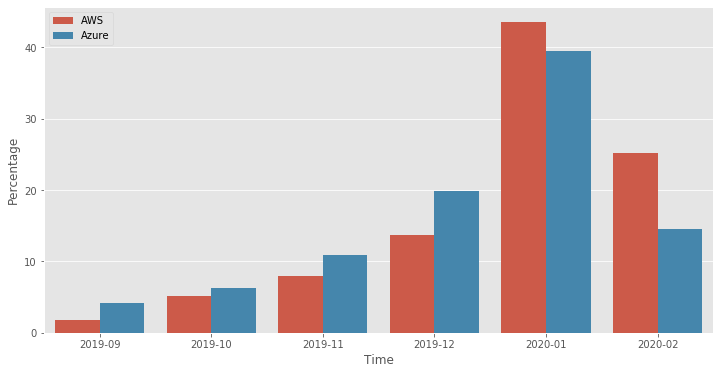

In [63]:
plt.figure(figsize=(12,6))
sb.barplot(comp_time['Time'], comp_time['Percentage'],
                comp_time['Company'],hue_order=['AWS','Azure'])
plt.legend(loc='upper left')
plt.savefig('time_plot_'+aws_date+'.png')

### <font color=green> Conclusion</font>

AWS has more new positions. If we assume the hiring process takes about the same time, AWS' hiring rate is higher than Azure recently.

## <font color=blue> Job Categories </font>

In [64]:
aws_title = ' '.join(aws['title'])
aws_title = collections.Counter(aws_title.split())
aws_title_count = pd.DataFrame({'word': list(aws_title.keys()), 
                                'count': list(aws_title.values())})
aws_title_count = aws_title_count.sort_values(by='count',ascending=False)
aws_title_count.to_csv('title_counts_aws.csv')

In [65]:
azure_title = ' '.join(azure['title'])
azure_title = collections.Counter(azure_title.split())
azure_title_count = pd.DataFrame({'word': list(azure_title.keys()), 
                                'count': list(azure_title.values())})
azure_title_count = azure_title_count.sort_values(by='count',ascending=False)
azure_title_count.to_csv('title_counts_azure.csv')

In [66]:
comp_category = []

In [67]:
job_keywords = ['engineer','sde','developer']
counts = len(aws[aws['title'].map(lambda x: 
                                  any([key in x.split() for key in job_keywords]))])
comp_category.append(['Engineer',counts/aws.shape[0],'AWS'])

In [68]:
job_keywords = ['engineer','sde','developer']
counts = len(azure[azure['title'].map(lambda x: 
                                      any([key in x.split() for key in job_keywords]))])
comp_category.append(['Engineer',counts/azure.shape[0],'Azure'])

In [69]:
job_keywords = ['solutions architect','solution architect']
counts = len(aws[aws['title'].map(lambda x: 
                                  any([x.find(key) != -1 for key in job_keywords]))])
comp_category.append(['Solution Architect',counts/aws.shape[0],'AWS'])

In [70]:
job_keywords = ['solutions architect','solution architect']
counts = len(azure[azure['title'].map(lambda x: 
                                      any([x.find(key) != -1 for key in job_keywords]))])
comp_category.append(['Solution Architect',counts/azure.shape[0],'Azure'])

In [71]:
job_keywords = ['data scientist']
counts = len(aws[aws['title'].map(lambda x: 
                                  any([x.find(key) != -1 for key in job_keywords]))])
comp_category.append(['Data Scientist',counts/aws.shape[0],'AWS'])

In [72]:
job_keywords = ['data scientist']
counts = len(azure[azure['title'].map(lambda x: 
                                  any([x.find(key) != -1 for key in job_keywords]))])
comp_category.append(['Data Scientist',counts/azure.shape[0],'Azure'])

In [73]:
job_keywords = ['manager','director']
counts = len(aws[aws['title'].map(lambda x: 
                                  any([key in x.split() for key in job_keywords]))])
comp_category.append(['Manager',counts/aws.shape[0],'AWS'])

In [74]:
job_keywords = ['manager','director']
counts = len(azure[azure['title'].map(lambda x: 
                                  any([key in x.split() for key in job_keywords]))])
comp_category.append(['Manager',counts/aws.shape[0],'Azure'])

### <font color=green> Plot </font>

In [75]:
comp_category = pd.DataFrame(comp_category,columns = ['Job','Percentage','Company'])

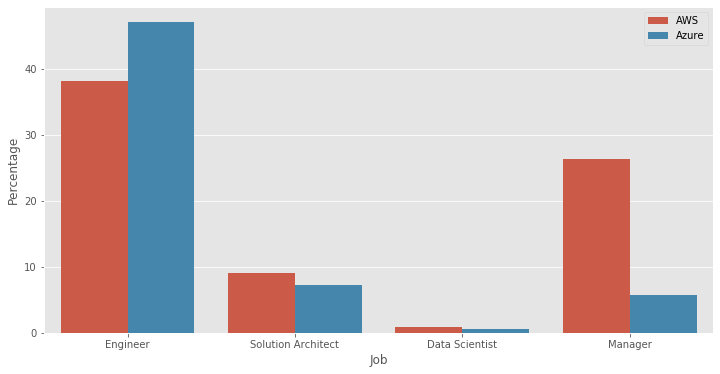

In [76]:
plt.figure(figsize=(12,6))
sb.barplot(comp_category['Job'], comp_category['Percentage']*100,
                comp_category['Company'],hue_order=['AWS','Azure'])
plt.legend(loc='upper right')
plt.savefig('category_plot.png')

### <font color=green> Conclusion</font>

Azure has higher percentage of engineers. A quarter of the positions in AWS are managers.

## <font color=blue> Skills </font>

In [77]:
# Use TextBlob to generate ngrams(2)

# azure_skill = ' '.join(azure['qualifications'])
# stop_words = set(stopwords.words('english'))
# skill_tokens = word_tokenize(azure_skill)
# skill_filtered = [w for w in skill_tokens if w not in stop_words]
# two = TextBlob(' '.join(skill_filtered)).ngrams(2)
# two = [tuple(l) for i,l in enumerate(two)]
# two_count = collections.Counter(two)
# two_count = collections.Counter(two)
# two_count = pd.DataFrame({'word': list(two_count.keys()), 
#                                 'count': list(two_count.values())})
# two_count = two_count.sort_values(by='count',ascending=False)
# two_count.to_csv('two_counts_aws.csv')

In [78]:
# Take a look at the word counts.

# azure_skill = ' '.join(azure['qualifications']).split()
# stop_words = set(stopwords.words('english'))
# azure_skill = [w for w in azure_skill if w not in stop_words]
# azure_skill = collections.Counter(azure_skill)
# azure_skill_count = pd.DataFrame({'word': list(azure_skill.keys()), 
#                                 'count': list(azure_skill.values())})
# azure_skill_count = azure_skill_count.sort_values(by='count',ascending=False)
# azure_skill_count.to_csv('skill_counts_azure.csv')

In [79]:
skills = ['java','sql','python','linux','javascript','kubernetes','spark','r',\
          'js','nosql','mysql','hadoop','php','postgresql','jenkins','ruby','perl',\
          'docker','github','git','tensorflow','kafka','matlab','assembly','go','scala',\
          'delphi','swift','c']
skills_raw = ['C++','C#']

### <font color=green> Azure </font>

In [80]:
azure_skill = ' '.join(azure['qualifications']).split()
azure_skill_raw = ' '.join(azure_raw['qualifications']).split()
stop_words = set(stopwords.words('english'))
azure_skill = [w for w in azure_skill if w not in stop_words]

In [81]:
dict_s = {}
for s in skills:
    dict_s[s] = azure_skill.count(s)

In [82]:
mask = azure_raw[['title','description','responsibilites']].apply(lambda x: 
                                    x.str.contains('azure',case=False)).any(axis=1)
azure_raw_pure = azure_raw[mask]

In [83]:
len(azure),len(azure_raw_pure),len(azure_raw)

(3723, 3775, 4494)

In [84]:
azure_skill_raw_pure = ' '.join(azure_raw_pure['qualifications'])

In [85]:
for s in skills_raw:
    dict_s[s] = azure_skill_raw_pure.count(s)

In [86]:
dict_s['c'] = dict_s['c'] - dict_s['C++'] - dict_s['C#']

In [87]:
comp_skill_azure = pd.DataFrame({'Skill':list(dict_s.keys()),
                                 'Counts':list(dict_s.values())})

### <font color=green> AWS</font>

In [88]:
aws_skill = ' '.join(aws['basic_qualifications']).split() + \
            ' '.join(aws['preferred_qualifications']).split()
aws_skill = [w for w in aws_skill if w not in stop_words]

In [89]:
dict_s = {}
for s in skills:
    dict_s[s] = aws_skill.count(s)

In [90]:
mask = aws_raw[['title','description']].apply(lambda x: 
                        x.str.contains('aws|amazon web services',case=False)).any(axis=1)
aws_raw_pure = aws_raw[mask]

In [91]:
len(aws),len(aws_raw_pure),len(aws_raw)

(14421, 14421, 16824)

In [92]:
aws_skill_raw_pure = ' '.join(aws_raw_pure['basic_qualifications'])+' '+\
                     ' '.join(aws_raw_pure['preferred_qualifications'])

In [93]:
for s in skills_raw:
    dict_s[s] = aws_skill_raw_pure.count(s)

In [94]:
dict_s['c'] = dict_s['c'] - dict_s['C++'] - dict_s['C#']

In [95]:
comp_skill_aws = pd.DataFrame({'Skill':list(dict_s.keys()),
                                 'Counts': list(dict_s.values())})

In [96]:
comp_skill = pd.merge(comp_skill_aws,comp_skill_azure,on='Skill')

### <font color=green> Plot </font>

In [97]:
comp_skill.columns = ['Skill','AWS','Azure']

In [98]:
comp_skill = comp_skill.sort_values(by='AWS',ascending=False)
top = 12
comp_skill_top = comp_skill.nlargest(top,'AWS')

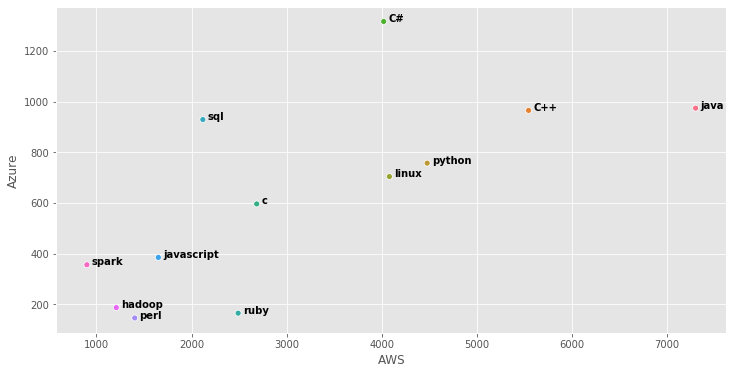

In [99]:
plt.figure(figsize=(12,6))
sb.scatterplot(comp_skill_top['AWS'], comp_skill_top['Azure'],
                comp_skill_top['Skill'],legend=None)
for i in range(top):
    plt.text(comp_skill_top.iloc[i,1]+50,comp_skill_top.iloc[i,2],comp_skill_top.iloc[i,0],
             horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.savefig('skill_plot.png')

### <font color=green> Conclusion</font>

AWS uses Java and Ruby more often than Azure. Azure uses C# and SQL more often than AWS.

## <font color=blue> Mention Each Other </font>

In [100]:
comp_each_other = comp_skill_top.append(pd.DataFrame([['AWS/Azure',aws_skill.count('azure'),
                                         azure_skill.count('aws')]],
                                       columns = comp_skill_top.columns))

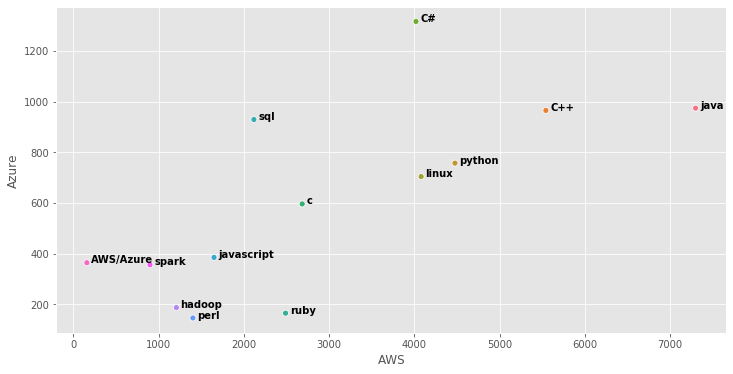

In [101]:
plt.figure(figsize=(12,6))
sb.scatterplot(comp_each_other['AWS'], comp_each_other['Azure'],
                comp_each_other['Skill'],legend = None)
for i in range(top+1):
    plt.text(comp_each_other.iloc[i,1]+50,comp_each_other.iloc[i,2],comp_each_other.iloc[i,0],
             horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.savefig('each_other_plot.png')

### <font color=green> Conclusion</font>

Azure mentions AWS more often than AWS mentions Azure.

## <font color=blue> Future Work </font>

Stratification of different features, e.g., time series analysis in domestic and international hires.